In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset testing

In [3]:
import torch.utils.data as data
from torchvision import transforms

In [ ]:
class OccMapDataset(data.Dataset):
    def __init__(self, filename='./description_ang0.csv', transform=None, input_dir='./inp_data/', target_dir='./gt_data/'):
        # Your code 
        df = pd.read_csv(filename)
        df = df[df['free_perc'] <= 80]
        self.filepaths = my_df['Filename'].values
        
        self.transform = transform
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        # Your code 
        return len(self.filepaths)
    
    def __getitem__(self, index):
        # Your code
        filename = self.filepaths[index]
        inp_img = np.load(f'{self.input_dir}/{my_filenames[0]}.npy')
        tgt_img = np.load(f'{self.output_dir}/{my_filenames[0]}.npy')
        
        data_dict = {'input image': inp_img, 'target image': tgt_img}
        
        if self.transform is not None:
            data_dict['input image'] = self.transform(data_dict['input image'])
            data_dict['target image'] = self.transform(data_dict['target image'])
        
        return data_dict

In [48]:
my_df = pd.read_csv('description_ang0.csv')
my_df.head()

,Unnamed: 0,Filename,FloorName,pos_x,pos_y,pos_z,ang_x,ang_y,ang_z,free_perc
0,0,FP201_0,FloorPlan201,-4.0,0.902657,1.5,0,0,0,71.540833
1,1,FP201_1,FloorPlan201,-4.0,0.902657,1.5,0,45,0,72.044373
2,2,FP201_2,FloorPlan201,-4.0,0.902657,1.5,0,90,0,68.254089
3,3,FP201_3,FloorPlan201,-4.0,0.902657,1.5,0,135,0,76.741028
4,4,FP201_4,FloorPlan201,-4.0,0.902657,1.5,0,180,0,84.309387


In [49]:
my_df.shape

(15096, 10)

<AxesSubplot:>

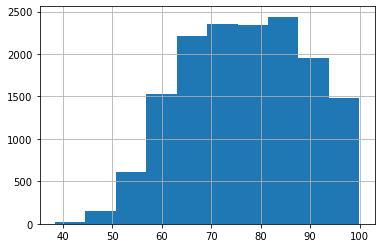

In [50]:
my_df['free_perc'].hist()

In [51]:
my_df = my_df[my_df['free_perc'] <= 80]
my_filenames = my_df['Filename'].values
print(len(my_filenames))

8641


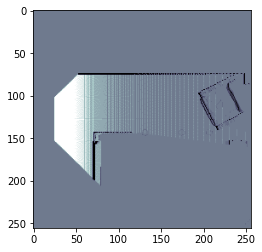

In [52]:
plt.imshow(np.load(f'inp_data/{my_filenames[0]}.npy'), cmap='bone_r')

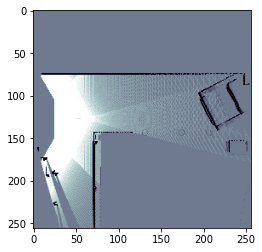

In [53]:
plt.imshow(np.load(f'gt_data/{my_filenames[0]}.npy'), cmap='bone_r')

In [1]:
import torch
from dataloader import OccMapDataset
from torchvision import transforms

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ConvertImageDtype(torch.float)
            ])
# load the data
full_set = OccMapDataset(filename='./description_ang0.csv', transform=transform)

In [3]:
full_loader = torch.utils.data.DataLoader(full_set, batch_size=12, shuffle=True, num_workers=2)

In [4]:
for data in full_loader:
    break

In [5]:
data['input image'].shape, data['target image'].shape

(torch.Size([12, 1, 256, 256]), torch.Size([12, 1, 256, 256]))

In [6]:
full_loader.batch_size

12

## Solver

In [54]:
from torch.utils.tensorboard import SummaryWriter

In [55]:
import torch.nn as nn

In [ ]:
nn.MSELoss()